---
## 1. Configuration & Setup

In [ ]:
# === IMPORTS ===
import os
import glob
import json
import warnings
from typing import Dict, List, Tuple, Optional, Any

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Progress Bar
from tqdm.notebook import tqdm

# Suppress warnings
warnings.simplefilter("ignore")

# Plot settings
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA available: False


In [ ]:
# === UTILITY FUNCTIONS ===
# Defined early for use throughout the notebook

def calc_nse(obs: np.ndarray, sim: np.ndarray) -> float:
    """
    Calculate Nash-Sutcliffe Efficiency (NSE).
    
    NSE = 1 - sum((obs - sim)^2) / sum((obs - mean(obs))^2)
    
    Args:
        obs: Observed streamflow values (m³/s, normalized).
        sim: Simulated/predicted streamflow values (m³/s, normalized).
    
    Returns:
        NSE value. 1.0 = perfect, 0.0 = mean prediction, <0 = worse than mean.
    """
    denominator = np.sum((obs - np.mean(obs)) ** 2) + 1e-6
    numerator = np.sum((sim - obs) ** 2)
    return 1 - (numerator / denominator)


def save_results(results: Dict[str, Any], params: Dict[str, Any], output_dir: str) -> None:
    """
    Save model metrics and training parameters to JSON files.
    
    Args:
        results: Dictionary of evaluation metrics (e.g., {'NSE': 0.85}).
        params: Dictionary of hyperparameters used for training.
        output_dir: Directory path to save the JSON files.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    with open(os.path.join(output_dir, 'params.json'), 'w') as f:
        params_clean = {k: str(v) for k, v in params.items()}
        json.dump(params_clean, f, indent=4)
    
    print(f"Results saved to {output_dir}")


print("Utility functions defined: calc_nse(), save_results()")

In [ ]:
# === CONFIGURATION ===
# All constants and hyperparameters in one place for easy modification

class Config:
    """
    Central configuration for the CAMELS prediction pipeline.
    
    Key Hyperparameters Summary:
    ┌─────────────────┬─────────┬────────────────────────────────────┐
    │ Parameter       │ Value   │ Description                        │
    ├─────────────────┼─────────┼────────────────────────────────────┤
    │ SEQ_LENGTH      │ 60      │ Input sequence length (days)       │
    │ PREDICT_HORIZON │ 2       │ Task 1: predict t+2                │
    │ PREDICT_STEPS   │ 5       │ Task 2: predict t+1 to t+5         │
    │ HIDDEN_DIM      │ 64      │ LSTM hidden units                  │
    │ DROPOUT         │ 0.2     │ Regularization                     │
    │ LEARNING_RATE   │ 0.001   │ Adam optimizer LR                  │
    │ BATCH_SIZE      │ 256     │ Training batch size                │
    │ EPOCHS          │ 10      │ Training epochs                    │
    └─────────────────┴─────────┴────────────────────────────────────┘
    """
    
    # ==================== PATHS ====================
    BASE_DIR: str = 'basin_dataset_public'
    FORCING_DIR: str = os.path.join(BASE_DIR, 'basin_mean_forcing', 'nldas')
    FLOW_DIR: str = os.path.join(BASE_DIR, 'usgs_streamflow')
    BAD_BASINS_FILE: str = os.path.join(BASE_DIR, 'basin_size_errors_10_percent.txt')
    RESULTS_DIR: str = 'results'
    
    # Static attribute files
    STATIC_FILES: List[str] = [
        'camels_topo.txt',   # Elevation, Slope, Area
        'camels_soil.txt',   # Sand, Clay, Porosity
        'camels_clim.txt',   # Precip, Aridity, Snow Fraction
        'camels_vege.txt',   # Forest fraction, LAI
        'camels_geol.txt',   # Rock types, Permeability
    ]
    
    # ==================== CONSTANTS ====================
    CFS_TO_CMS: float = 0.0283168  # Cubic feet/s → Cubic meters/s
    
    # ==================== EXPERIMENT ====================
    USE_STATIC: bool = True   # Include static catchment attributes
    NUM_BASINS: int = 5       # Number of basins to load (0 = all)
    
    # ==================== MODEL HYPERPARAMETERS ====================
    SEQ_LENGTH: int = 60          # Lookback window (days)
    PREDICT_HORIZON: int = 2      # Task 1: Predict t+k
    PREDICT_STEPS: int = 5        # Task 2: Predict sequence t+1...t+5
    HIDDEN_DIM: int = 64          # LSTM hidden units
    DROPOUT: float = 0.2          # Dropout rate
    LEARNING_RATE: float = 0.001  # Adam learning rate
    TEACHER_FORCING: float = 0.5  # Teacher forcing ratio for Seq2Seq
    
    # ==================== TRAINING ====================
    EPOCHS: int = 10
    BATCH_SIZE: int = 256
    USE_GPU: bool = True
    
    # ==================== DATA SPLIT (Hydrological Years) ====================
    # Standard CAMELS split (no data leakage: Train → Val → Test)
    TRAIN_START: str = '1980-10-01'
    TRAIN_END: str = '1995-09-30'
    VAL_START: str = '1995-10-01'
    VAL_END: str = '2000-09-30'
    TEST_START: str = '2000-10-01'
    TEST_END: str = '2010-09-30'
    
    # ==================== FEATURES ====================
    # Dynamic Inputs (Time-Series)
    DYNAMIC_FEATURES: List[str] = [
        'PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp',   # Original Forcing (mm/day, W/m², °C, °C, Pa)
        'PRCP_roll3', 'PRCP_roll7',             # Rolling Stats (mm/day)
        'Q_lag1', 'Q_lag2', 'Q_lag3'            # Lag Features (m³/s)
    ]
    
    # Static Inputs (Basin Attributes)
    STATIC_FEATURES: List[str] = [
        'area_gages2',  # Catchment Area (km², log-transformed)
        'elev_mean',    # Mean Elevation (m)
        'slope_mean',   # Topography (m/km)
        'sand_frac',    # Soil Type (fraction)
        'clay_frac',    # Soil Type (fraction)
        'frac_forest',  # Vegetation (fraction)
        'lai_max',      # Leaf Area Index (-)
        'p_mean',       # Long-term precipitation (mm/day)
        'aridity'       # Climate Index (-)
    ]
    
    TARGET: str = 'Q_cms'  # Target variable: streamflow (m³/s)

# Initialize config
cfg = Config()

# Set device
device = torch.device('cuda' if cfg.USE_GPU and torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [31]:
# === CHECK DATASET AVAILABILITY ===
dataset_exists = os.path.exists(cfg.BASE_DIR)

if dataset_exists:
    print(f"✓ Dataset found at: {os.path.abspath(cfg.BASE_DIR)}")
    # List contents
    contents = os.listdir(cfg.BASE_DIR)
    print(f"  Contents: {contents[:10]}{'...' if len(contents) > 10 else ''}")
else:
    print(f"✗ Dataset NOT found at: {os.path.abspath(cfg.BASE_DIR)}")
    print("\nPlease download the CAMELS dataset from:")
    print("  https://zenodo.org/records/15529996")
    print(f"\nAnd extract it to: {os.path.abspath(cfg.BASE_DIR)}")
    print("\nExpected structure:")
    print("  basin_dataset_public/")
    print("  ├── basin_mean_forcing/nldas/")
    print("  ├── usgs_streamflow/")
    print("  ├── camels_topo.txt")
    print("  ├── camels_soil.txt")
    print("  └── ...")

✓ Dataset found at: c:\Users\Quang Chien\main_source\hydrology-prediction\basin_dataset_public
  Contents: ['basin_mean_forcing', 'basin_metadata', 'basin_size_errors_10_percent.txt', 'dataset_summary.txt', 'elev_bands_forcing', 'hru_forcing', 'readme_basin_mean_forcing.txt', 'readme_elev_bands_forcing.txt', 'readme_FIRST.txt', 'readme_hru_forcing.txt']...


---
## 2. Data Loading

The `CamelsLoader` class handles all data I/O operations:
- Loading basin lists and filtering bad basins
- Loading dynamic time series (streamflow + forcing)
- Loading static catchment attributes

In [ ]:
# === DATA LOADER CLASS ===

class CamelsLoader:
    """
    Handles loading of CAMELS basin data.
    
    Responsibilities:
    - Load and filter basin lists (exclude bad basins)
    - Load dynamic time series (streamflow + meteorological forcing)
    - Load static catchment attributes
    """
    
    def __init__(self, config: Config) -> None:
        """
        Initialize the loader with configuration.
        
        Args:
            config: Config object containing paths and settings.
        """
        self.cfg = config
    
    def load_bad_basins(self) -> List[str]:
        """
        Load list of basin IDs to exclude due to area measurement errors.
        
        Returns:
            List of gauge_id strings to exclude.
        """
        if not os.path.exists(self.cfg.BAD_BASINS_FILE):
            return []
        
        bad_ids = []
        try:
            with open(self.cfg.BAD_BASINS_FILE, 'r') as f:
                next(f)  # Skip header
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        bad_ids.append(parts[1])
        except Exception as e:
            print(f"Failed to parse bad basins file: {e}")
        return bad_ids
    
    def get_basin_list(self) -> pd.DataFrame:
        """
        Scan directories and return DataFrame of valid basins.
        
        Returns:
            DataFrame with columns ['gauge_id', 'region'].
        """
        bad_basins = self.load_bad_basins()
        
        search_path = os.path.join(self.cfg.FLOW_DIR, '**', '*_streamflow_qc.txt')
        files = glob.glob(search_path, recursive=True)
        
        basins = []
        for f in files:
            parts = f.split(os.sep)
            region = parts[-2]
            gauge_id = parts[-1].split('_')[0]
            
            if gauge_id not in bad_basins:
                basins.append({'gauge_id': gauge_id, 'region': region})
        
        return pd.DataFrame(basins)
    
    def load_dynamic_data(self, gauge_id: str, region: str) -> Optional[pd.DataFrame]:
        """
        Load streamflow and forcing data for a single basin.
        
        Args:
            gauge_id: 8-digit USGS gauge identifier.
            region: 2-digit HUC region code.
        
        Returns:
            DataFrame indexed by Date with columns:
            - Q_cms: Streamflow (m³/s)
            - PRCP: Precipitation (mm/day)
            - SRAD: Solar radiation (W/m²)
            - Tmax, Tmin: Temperature (°C)
            - Vp: Vapor pressure (Pa)
            Returns None if data cannot be loaded.
        """
        # 1. Load Streamflow
        flow_path = os.path.join(self.cfg.FLOW_DIR, region, f'{gauge_id}_streamflow_qc.txt')
        try:
            df_flow = pd.read_csv(flow_path, delim_whitespace=True, header=None,
                                  names=['gauge_id', 'Year', 'Month', 'Day', 'Q_cfs', 'QC'])
        except:
            return None
        
        df_flow['Date'] = pd.to_datetime(df_flow[['Year', 'Month', 'Day']])
        df_flow.set_index('Date', inplace=True)
        # Convert cfs → cms; mark missing values (-999) as NaN
        df_flow['Q_cms'] = df_flow['Q_cfs'].replace(-999, np.nan) * self.cfg.CFS_TO_CMS
        
        # 2. Load Forcing (NLDAS)
        forcing_path = os.path.join(self.cfg.FORCING_DIR, region, 
                                    f'{gauge_id}_lump_nldas_forcing_leap.txt')
        if not os.path.exists(forcing_path):
            return None
        
        try:
            df_force = pd.read_csv(forcing_path, delim_whitespace=True, skiprows=3)
        except:
            return None
        
        # Normalize column names (handle variations in CAMELS files)
        col_map = {
            'Mnth': 'Month', 'month': 'Month', 'mo': 'Month',
            'year': 'Year', 'yr': 'Year',
            'day': 'Day', 'dy': 'Day',
            'prcp(mm/day)': 'PRCP', 'srad(w/m2)': 'SRAD',
            'tmax(c)': 'Tmax', 'tmin(c)': 'Tmin', 'vp(pa)': 'Vp'
        }
        
        new_cols = {}
        for c in df_force.columns:
            clean = c.strip()
            if clean.lower() in col_map:
                new_cols[c] = col_map[clean.lower()]
            elif clean in col_map:
                new_cols[c] = col_map[clean]
        
        df_force.rename(columns=new_cols, inplace=True)
        
        try:
            df_force['Date'] = pd.to_datetime(df_force[['Year', 'Month', 'Day']])
            df_force.set_index('Date', inplace=True)
        except KeyError:
            return None
        
        # 3. Merge flow and forcing
        base_forcing = ['PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp']
        cols_to_use = [c for c in base_forcing if c in df_force.columns]
        df_merged = df_flow[['Q_cms']].join(df_force[cols_to_use], how='inner')
        
        return df_merged
    
    def load_static_attributes(self, basins_list: Optional[List[str]] = None) -> Optional[pd.DataFrame]:
        """
        Load all static attribute files and merge them.
        
        Args:
            basins_list: Optional list of gauge_ids to filter. If None, returns all.
        
        Returns:
            DataFrame indexed by gauge_id with static features as columns.
            Returns None if no files found.
        """
        dfs = []
        for filename in self.cfg.STATIC_FILES:
            path = os.path.join(self.cfg.BASE_DIR, filename)
            if os.path.exists(path):
                try:
                    df = pd.read_csv(path, sep=';')
                    df.columns = [c.strip() for c in df.columns]
                    if 'gauge_id' in df.columns:
                        df['gauge_id'] = df['gauge_id'].astype(str).str.zfill(8)
                        df.set_index('gauge_id', inplace=True)
                        dfs.append(df)
                except:
                    pass
        
        if not dfs:
            return None
        
        # Merge all static files
        df_static = pd.concat(dfs, axis=1)
        df_static = df_static.loc[:, ~df_static.columns.duplicated()]
        
        # Filter for configured features
        available_feats = [f for f in self.cfg.STATIC_FEATURES if f in df_static.columns]
        df_final = df_static[available_feats]
        
        if basins_list is not None:
            df_final = df_final.reindex(basins_list)
        
        return df_final

# Initialize loader
loader = CamelsLoader(cfg)
print("CamelsLoader initialized.")

CamelsLoader initialized.


In [33]:
# === LOAD BASIN LIST ===
if dataset_exists:
    df_basins = loader.get_basin_list()
    
    print(f"Total valid basins found: {len(df_basins)}")
    print(f"\nRegion distribution:")
    print(df_basins['region'].value_counts().head(10))
    
    # Preview
    display(df_basins.head())
else:
    print("Dataset not available. Please download first.")

Total valid basins found: 608

Region distribution:
region
17    83
03    82
10    69
02    69
05    43
12    36
07    33
04    31
11    30
18    27
Name: count, dtype: int64


,gauge_id,region
0,01013500,01
1,01022500,01
2,01030500,01
3,01031500,01
4,01047000,01


In [34]:
# === LOAD SAMPLE BASIN DATA ===
if dataset_exists and len(df_basins) > 0:
    # Load one basin for inspection
    sample_row = df_basins.iloc[0]
    sample_id = sample_row['gauge_id']
    sample_region = sample_row['region']
    
    print(f"Loading sample basin: {sample_id} (Region: {sample_region})")
    df_sample = loader.load_dynamic_data(sample_id, sample_region)
    
    if df_sample is not None:
        print(f"\nShape: {df_sample.shape}")
        print(f"Date range: {df_sample.index.min()} to {df_sample.index.max()}")
        print(f"\nColumns: {df_sample.columns.tolist()}")
        print(f"\nMissing values:")
        print(df_sample.isna().sum())
        print(f"\n")
        display(df_sample.head(10))
    else:
        print("Failed to load sample basin.")
else:
    print("Dataset not available.")

Loading sample basin: 01013500 (Region: 01)

Shape: (12784, 6)
Date range: 1980-01-01 00:00:00 to 2014-12-31 00:00:00

Columns: ['Q_cms', 'PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp']

Missing values:
Q_cms    92
PRCP      0
SRAD      0
Tmax      0
Tmin      0
Vp        0
dtype: int64




,Q_cms,PRCP,SRAD,Tmax,Tmin,Vp
Date,,,,,,
1980-01-01,18.547504,0.00,218.66,-13.04,-13.04,203.28
1980-01-02,18.122752,0.00,199.05,-10.93,-10.93,237.37
1980-01-03,17.698000,0.00,197.64,-13.60,-13.60,169.39
1980-01-04,17.556416,0.00,214.61,-16.53,-16.53,134.57
1980-01-05,17.131664,0.00,206.02,-17.60,-17.60,129.30
1980-01-06,16.565328,1.23,203.38,-20.35,-20.35,103.99
1980-01-07,16.140576,3.07,158.00,-14.23,-14.23,202.78
1980-01-08,15.715824,1.17,108.70,-6.36,-6.36,310.48
1980-01-09,15.291072,0.05,136.21,-11.79,-11.79,196.68


In [35]:
# === LOAD STATIC ATTRIBUTES ===
if dataset_exists:
    df_static = loader.load_static_attributes()
    
    if df_static is not None:
        print(f"Static attributes shape: {df_static.shape}")
        print(f"\nFeatures loaded: {df_static.columns.tolist()}")
        print(f"\n")
        display(df_static.head())
    else:
        print("No static attribute files found.")
else:
    print("Dataset not available.")

No static attribute files found.


---
## 3. Exploratory Data Analysis (EDA)

Visualizations to understand:
- Single basin time series characteristics
- Flow duration curves
- Seasonality patterns
- Autocorrelation and cross-correlation (lag analysis)
- Global statistics across all basins
- Static feature distributions

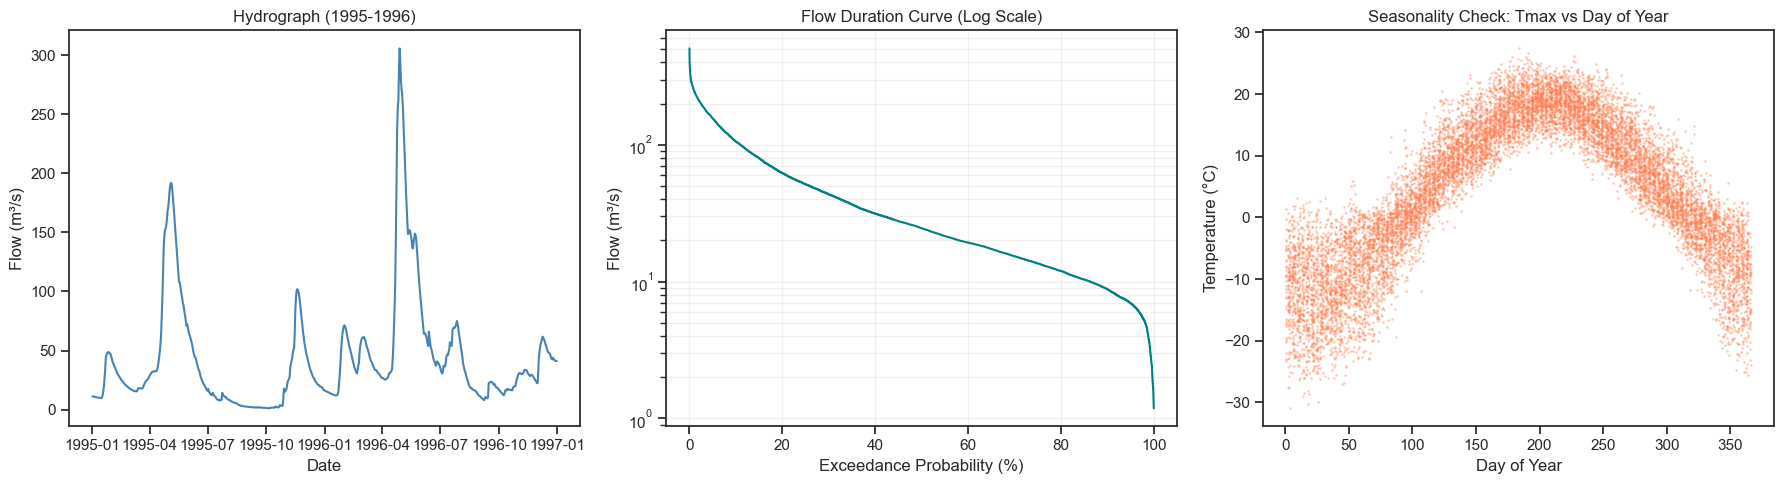

In [36]:
# === 3.1 SINGLE BASIN ANALYSIS ===
if dataset_exists and df_sample is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Hydrograph (2 year subset)
    try:
        subset = df_sample['1995':'1996']
        if subset.empty:
            raise ValueError("Empty slice")
        title_text = "Hydrograph (1995-1996)"
    except:
        subset = df_sample.iloc[:730]
        title_text = "Hydrograph (First 2 Years)"
    
    axes[0].plot(subset.index, subset['Q_cms'], label='Flow', color='steelblue')
    axes[0].set_title(title_text)
    axes[0].set_ylabel("Flow (m³/s)")
    axes[0].set_xlabel("Date")
    
    # 2. Flow Duration Curve (FDC)
    sorted_flow = np.sort(df_sample['Q_cms'].dropna())[::-1]
    exceedance = np.arange(1, len(sorted_flow)+1) / len(sorted_flow) * 100
    axes[1].semilogy(exceedance, sorted_flow, color='teal')
    axes[1].set_title("Flow Duration Curve (Log Scale)")
    axes[1].set_xlabel("Exceedance Probability (%)")
    axes[1].set_ylabel("Flow (m³/s)")
    axes[1].grid(True, which="both", ls="-", alpha=0.3)
    
    # 3. Seasonality Check (Tmax vs Day of Year)
    if 'Tmax' in df_sample.columns:
        axes[2].scatter(df_sample.index.dayofyear, df_sample['Tmax'], 
                       s=1, alpha=0.3, c='coral')
        axes[2].set_title("Seasonality Check: Tmax vs Day of Year")
        axes[2].set_xlabel("Day of Year")
        axes[2].set_ylabel("Temperature (°C)")
    
    plt.tight_layout()
    plt.show()
else:
    print("Dataset not available for EDA.")

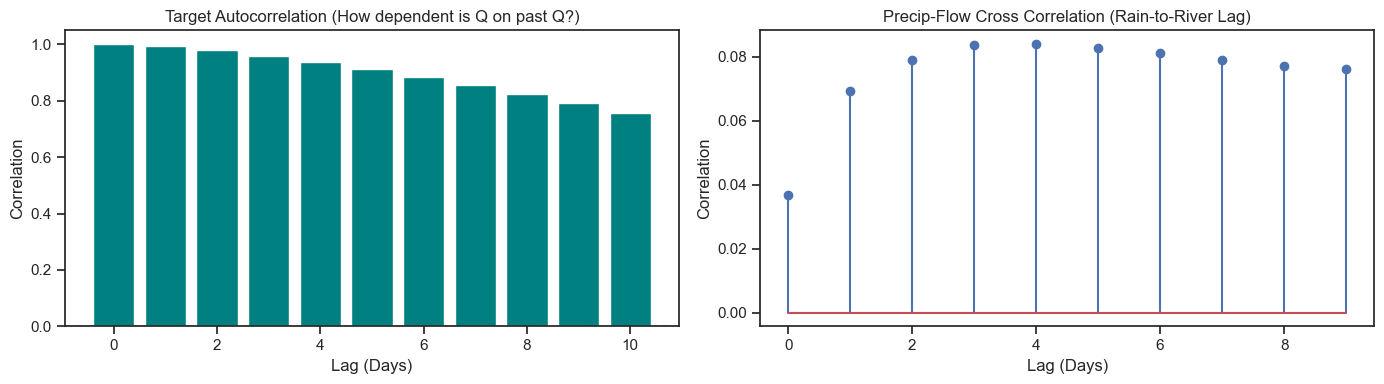

\n📊 Key Insights:
  • Lag-1 autocorrelation: 0.994 (High = Strong memory)
  • Peak PRCP-Q correlation at lag: 4 days


In [37]:
# === 3.2 LAG ANALYSIS FOR FORECASTING ===
if dataset_exists and df_sample is not None:
    clean_df = df_sample.dropna()
    lags = 10
    
    # Calculate correlations
    auto_corr = acf(clean_df['Q_cms'], nlags=lags)
    cross_corr = [clean_df['Q_cms'].corr(clean_df['PRCP'].shift(i)) for i in range(lags)]
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    
    # Autocorrelation (Memory)
    ax[0].bar(range(len(auto_corr)), auto_corr, color='teal')
    ax[0].set_title("Target Autocorrelation (How dependent is Q on past Q?)")
    ax[0].set_xlabel("Lag (Days)")
    ax[0].set_ylabel("Correlation")
    ax[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Cross Correlation (Response Time)
    ax[1].stem(range(lags), cross_corr)
    ax[1].set_title("Precip-Flow Cross Correlation (Rain-to-River Lag)")
    ax[1].set_xlabel("Lag (Days)")
    ax[1].set_ylabel("Correlation")
    
    plt.tight_layout()
    plt.show()
    
    print("\\n📊 Key Insights:")
    print(f"  • Lag-1 autocorrelation: {auto_corr[1]:.3f} (High = Strong memory)")
    print(f"  • Peak PRCP-Q correlation at lag: {np.argmax(cross_corr)} days")
else:
    print("Dataset not available for lag analysis.")

In [38]:
# === 3.3 GLOBAL STATISTICS (ALL BASINS) ===
# This cell processes multiple basins - may take a few minutes

if dataset_exists:
    global_stats = []
    basins_to_process = df_basins.head(min(100, len(df_basins)))  # Limit for speed
    
    print(f"Processing {len(basins_to_process)} basins for global statistics...")
    
    for idx, row in tqdm(basins_to_process.iterrows(), total=len(basins_to_process)):
        df = loader.load_dynamic_data(row['gauge_id'], row['region'])
        
        if df is None or len(df) < 365:
            continue
        
        total_days = len(df)
        missing_q = df['Q_cms'].isna().sum()
        neg_flows = (df['Q_cms'] < 0).sum()
        
        mean_q = df['Q_cms'].mean()
        std_q = df['Q_cms'].std()
        cv_q = std_q / mean_q if mean_q > 0 else 0
        
        lag1_corr = df['Q_cms'].corr(df['Q_cms'].shift(1))
        
        global_stats.append({
            'gauge_id': row['gauge_id'],
            'region': row['region'],
            'missing_pct': (missing_q / total_days) * 100,
            'negative_q_count': neg_flows,
            'mean_flow_cms': mean_q,
            'cv_flow': cv_q,
            'lag1_autocorr': lag1_corr
        })
    
    df_global = pd.DataFrame(global_stats)
    
    print("\\n[Global Data Quality Summary]")
    display(df_global.describe().T[['mean', 'min', '50%', 'max']])
else:
    print("Dataset not available.")

Processing 100 basins for global statistics...


  0%|          | 0/100 [00:00<?, ?it/s]

\n[Global Data Quality Summary]


,mean,min,50%,max
missing_pct,0.954139,0.000000,0.500626,4.396767
negative_q_count,0.000000,0.000000,0.000000,0.000000
mean_flow_cms,7.342212,0.101898,4.041483,77.926589
cv_flow,1.677562,0.902992,1.659052,2.825861
lag1_autocorr,0.676411,0.288817,0.673462,0.993996


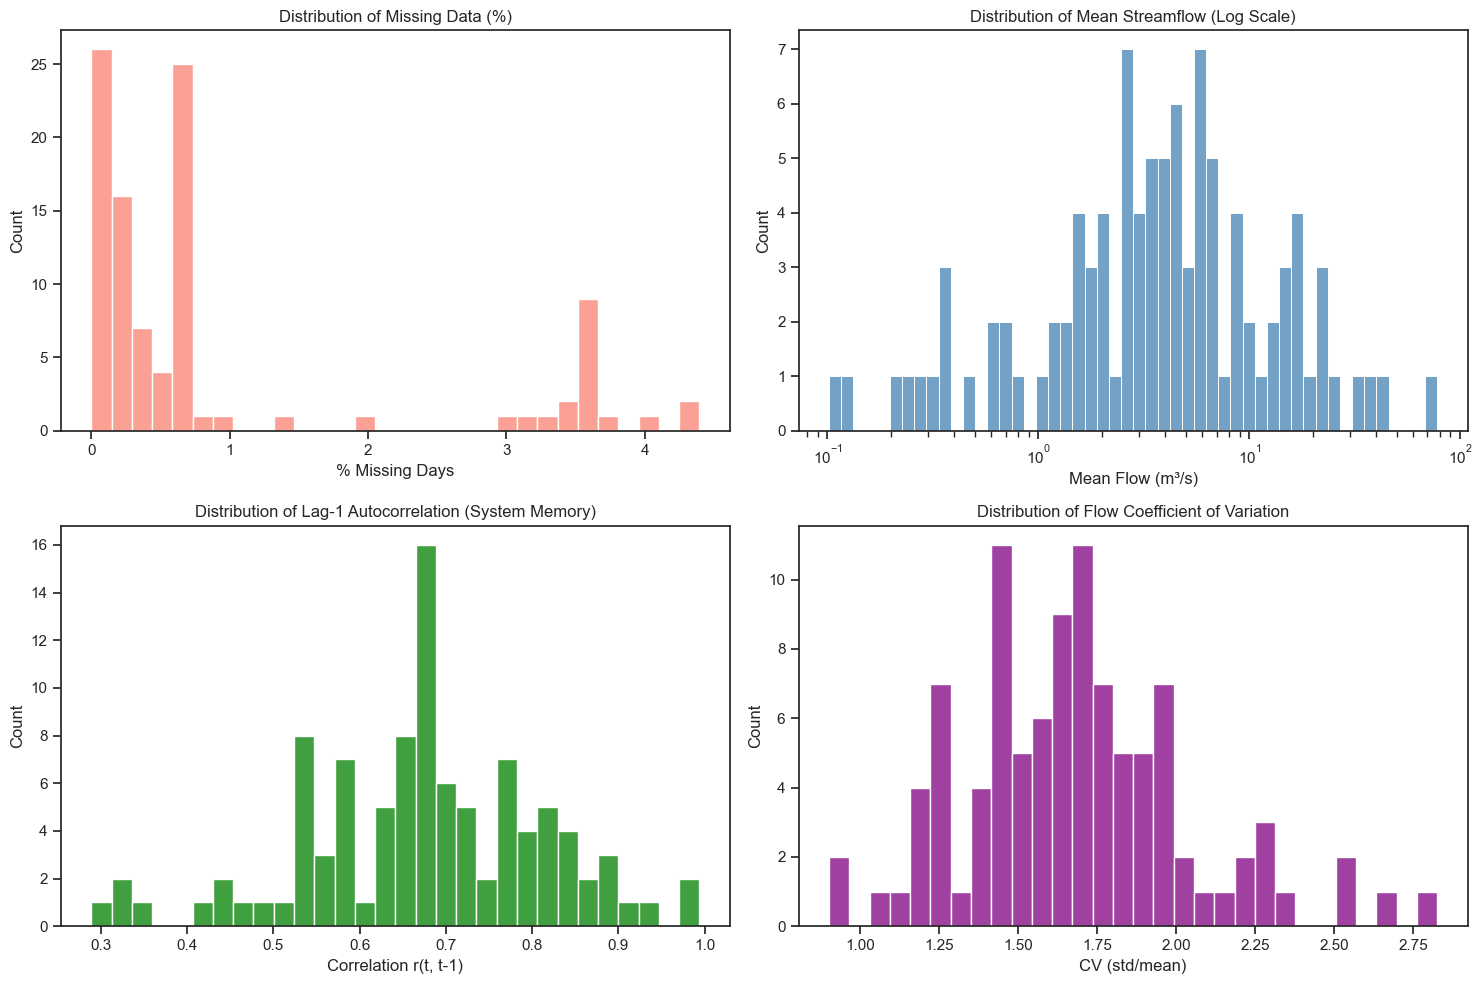

In [39]:
# === 3.4 GLOBAL DISTRIBUTION PLOTS ===
if dataset_exists and len(global_stats) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Missing Data Histogram
    sns.histplot(df_global['missing_pct'], bins=30, ax=axes[0,0], color='salmon')
    axes[0,0].set_title("Distribution of Missing Data (%)")
    axes[0,0].set_xlabel("% Missing Days")
    
    # 2. Basin Scale (Mean Flow - Log)
    sns.histplot(df_global['mean_flow_cms'], bins=50, log_scale=True, ax=axes[0,1], color='steelblue')
    axes[0,1].set_title("Distribution of Mean Streamflow (Log Scale)")
    axes[0,1].set_xlabel("Mean Flow (m³/s)")
    
    # 3. System Memory (Lag-1 Autocorrelation)
    sns.histplot(df_global['lag1_autocorr'], bins=30, ax=axes[1,0], color='green')
    axes[1,0].set_title("Distribution of Lag-1 Autocorrelation (System Memory)")
    axes[1,0].set_xlabel("Correlation r(t, t-1)")
    
    # 4. Flow Variability (CV)
    sns.histplot(df_global['cv_flow'], bins=30, ax=axes[1,1], color='purple')
    axes[1,1].set_title("Distribution of Flow Coefficient of Variation")
    axes[1,1].set_xlabel("CV (std/mean)")
    
    plt.tight_layout()
    plt.show()
else:
    print("Global statistics not available.")

In [40]:
# === 3.5 STATIC FEATURES ANALYSIS ===
if dataset_exists and df_static is not None:
    # Key features to visualize
    key_features = ['area_gages2', 'elev_mean', 'aridity', 'sand_frac', 'frac_forest', 'p_mean']
    plot_feats = [f for f in key_features if f in df_static.columns]
    
    if plot_feats:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, feat in enumerate(plot_feats):
            sns.histplot(df_static[feat].dropna(), bins=30, ax=axes[i], color='teal')
            axes[i].set_title(f"Distribution of {feat}")
            axes[i].set_xlabel(feat)
        
        plt.suptitle("Key Static Feature Distributions", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("Static features not available.")

Static features not available.


---
## 4. Feature Engineering

Create derived features to improve model performance:
- **Rolling Statistics**: 3-day and 7-day precipitation averages (soil moisture proxy)
- **Lag Features**: Previous streamflow values (autoregressive input)

In [ ]:
# === FEATURE ENGINEER CLASS ===

class FeatureEngineer:
    """
    Creates derived features for the prediction model.
    
    Features added:
    - Rolling precipitation statistics (soil moisture proxy)
    - Lag features for streamflow (autoregressive input)
    """
    
    def __init__(self, config: Config) -> None:
        """
        Initialize with configuration.
        
        Args:
            config: Config object containing TARGET variable name.
        """
        self.cfg = config
    
    def add_rolling_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate rolling statistics for precipitation.
        
        Purpose: Represents accumulated soil moisture / antecedent wetness.
        
        Args:
            df: DataFrame with 'PRCP' column (mm/day).
        
        Returns:
            DataFrame with added columns:
            - PRCP_roll3: 3-day rolling mean (mm/day)
            - PRCP_roll7: 7-day rolling mean (mm/day)
        """
        if 'PRCP' in df.columns:
            df['PRCP_roll3'] = df['PRCP'].rolling(window=3, min_periods=1).mean()
            df['PRCP_roll7'] = df['PRCP'].rolling(window=7, min_periods=1).mean()
        return df
    
    def add_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add explicit lag features for streamflow.
        
        Purpose: Give model explicit access to recent flow values (autoregressive).
        
        Args:
            df: DataFrame with TARGET column (Q_cms in m³/s).
        
        Returns:
            DataFrame with added columns:
            - Q_lag1, Q_lag2, Q_lag3: Previous day flows (m³/s)
        """
        target = self.cfg.TARGET
        
        if target in df.columns:
            df['Q_lag1'] = df[target].shift(1)
            df['Q_lag2'] = df[target].shift(2)
            df['Q_lag3'] = df[target].shift(3)
            
            # Backfill NaNs created by shifting
            for col in ['Q_lag1', 'Q_lag2', 'Q_lag3']:
                df[col] = df[col].bfill()
        
        return df
    
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Run all feature engineering steps.
        
        Should be run AFTER cleaning, BEFORE normalization.
        
        Args:
            df: Raw DataFrame with forcing and streamflow columns.
        
        Returns:
            DataFrame with all derived features added.
        """
        df = self.add_rolling_features(df)
        df = self.add_lag_features(df)
        return df

# Initialize feature engineer
engineer = FeatureEngineer(cfg)
print("FeatureEngineer initialized.")

FeatureEngineer initialized.


In [42]:
# === TEST FEATURE ENGINEERING ===
if dataset_exists and df_sample is not None:
    # Apply feature engineering to sample
    df_engineered = engineer.transform(df_sample.copy())
    
    print("New features added:")
    new_cols = ['PRCP_roll3', 'PRCP_roll7', 'Q_lag1', 'Q_lag2', 'Q_lag3']
    print(f"  {[c for c in new_cols if c in df_engineered.columns]}")
    
    print(f"\\nShape before: {df_sample.shape}")
    print(f"Shape after:  {df_engineered.shape}")
    
    display(df_engineered.head(10))
else:
    print("Dataset not available.")

New features added:
  ['PRCP_roll3', 'PRCP_roll7', 'Q_lag1', 'Q_lag2', 'Q_lag3']
\nShape before: (12784, 6)
Shape after:  (12784, 11)


,Q_cms,PRCP,SRAD,Tmax,Tmin,Vp,PRCP_roll3,PRCP_roll7,Q_lag1,Q_lag2,Q_lag3
Date,,,,,,,,,,,
1980-01-01,18.547504,0.00,218.66,-13.04,-13.04,203.28,0.000000,0.000000,18.547504,18.547504,18.547504
1980-01-02,18.122752,0.00,199.05,-10.93,-10.93,237.37,0.000000,0.000000,18.547504,18.547504,18.547504
1980-01-03,17.698000,0.00,197.64,-13.60,-13.60,169.39,0.000000,0.000000,18.122752,18.547504,18.547504
1980-01-04,17.556416,0.00,214.61,-16.53,-16.53,134.57,0.000000,0.000000,17.698000,18.122752,18.547504
1980-01-05,17.131664,0.00,206.02,-17.60,-17.60,129.30,0.000000,0.000000,17.556416,17.698000,18.122752
1980-01-06,16.565328,1.23,203.38,-20.35,-20.35,103.99,0.410000,0.205000,17.131664,17.556416,17.698000
1980-01-07,16.140576,3.07,158.00,-14.23,-14.23,202.78,1.433333,0.614286,16.565328,17.131664,17.556416
1980-01-08,15.715824,1.17,108.70,-6.36,-6.36,310.48,1.823333,0.781429,16.140576,16.565328,17.131664
1980-01-09,15.291072,0.05,136.21,-11.79,-11.79,196.68,1.430000,0.788571,15.715824,16.140576,16.565328


---
## 5. Preprocessing

The `CamelsPreprocessor` handles:
- **Physical Outlier Cleaning**: Remove impossible values (negative rain, extreme temps)
- **Missing Data Handling**: Interpolation and fill strategies
- **Date Features**: Cyclical sin/cos encoding for day-of-year
- **Normalization**: Global dynamic normalization + basin-specific target normalization
- **Sequence Creation**: Sliding window sequences for LSTM input

In [ ]:
# === PREPROCESSOR CLASS ===

class CamelsPreprocessor:
    """
    Handles data cleaning, normalization, and sequence creation.
    
    Pipeline: clean_physical_outliers → handle_missing_data → add_date_features 
              → fit (compute stats) → transform (normalize) → create_sequences
    """
    
    def __init__(self, config: Config) -> None:
        """
        Initialize preprocessor with configuration.
        
        Args:
            config: Config object with feature lists and data split dates.
        """
        self.cfg = config
        self.scalers: Dict[str, np.ndarray] = {}        # Global normalization stats
        self.basin_scalers: Dict[str, Dict[str, float]] = {}  # Per-basin target stats
        
        # Physical Constraints (hydrological validity)
        self.PHYSICAL_LIMITS: Dict[str, Dict[str, Optional[float]]] = {
            'PRCP': {'min': 0.0, 'max': None},      # Precipitation ≥ 0
            'Q_cms': {'min': 0.0, 'max': None},     # Streamflow ≥ 0
            'Tmax': {'min': -60.0, 'max': 60.0},    # Realistic temp range
            'Tmin': {'min': -60.0, 'max': 60.0}
        }
        self.MAX_INTERPOLATE_GAP: int = 5  # Max days to interpolate
    
    def add_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add cyclical day-of-year features for seasonality.
        
        Args:
            df: DataFrame with DatetimeIndex.
        
        Returns:
            DataFrame with sin_doy and cos_doy columns (range: -1 to 1).
        """
        day_of_year = df.index.dayofyear
        df['sin_doy'] = np.sin(2 * np.pi * day_of_year / 365.0)
        df['cos_doy'] = np.cos(2 * np.pi * day_of_year / 365.0)
        return df
    
    def clean_physical_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Remove physically impossible values.
        
        - Negative precipitation/flow → 0
        - Unrealistic temperatures → NaN
        
        Args:
            df: Raw DataFrame with forcing and streamflow.
        
        Returns:
            DataFrame with outliers corrected.
        """
        # Negative Rain/Flow → 0
        for col in ['PRCP', self.cfg.TARGET]:
            if col in df.columns:
                mask = df[col] < 0
                if mask.any():
                    df.loc[mask, col] = 0.0
        
        # Unrealistic Temp → NaN
        for col in ['Tmax', 'Tmin']:
            if col in df.columns:
                limits = self.PHYSICAL_LIMITS[col]
                mask = (df[col] < limits['min']) | (df[col] > limits['max'])
                if mask.any():
                    df.loc[mask, col] = np.nan
        return df
    
    def handle_missing_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Interpolate and fill missing values.
        
        Strategy: Linear interpolation (up to MAX_INTERPOLATE_GAP days), 
                  then forward/backward fill for remaining.
        
        Args:
            df: DataFrame with potential NaN values.
        
        Returns:
            DataFrame with missing values filled.
        """
        cols_to_fix = [self.cfg.TARGET] + self.cfg.DYNAMIC_FEATURES
        cols_to_fix = [c for c in cols_to_fix if c in df.columns]
        
        for col in cols_to_fix:
            df[col] = df[col].interpolate(method='linear', 
                                          limit=self.MAX_INTERPOLATE_GAP, 
                                          limit_direction='both')
            df[col] = df[col].ffill().bfill()
        return df
    
    def fit(self, dynamic_data_dict: Dict[str, pd.DataFrame], 
            static_df: Optional[pd.DataFrame] = None) -> None:
        """
        Compute normalization statistics from TRAINING data only.
        
        Computes:
        1. Global mean/std for dynamic features (across all basins)
        2. Global mean/std for static features
        3. Per-basin mean/std for target variable (basin-specific scaling)
        
        Args:
            dynamic_data_dict: Dict mapping gauge_id → DataFrame with time series.
            static_df: Optional DataFrame with static attributes.
        """
        print("Computing global statistics...")
        
        # 1. Dynamic Stats (Global) - from training period only
        dyn_vals = []
        for gid, df in dynamic_data_dict.items():
            train_slice = df.loc[self.cfg.TRAIN_START:self.cfg.TRAIN_END]
            if not train_slice.empty:
                available_cols = [c for c in self.cfg.DYNAMIC_FEATURES if c in train_slice.columns]
                valid_rows = train_slice[available_cols].dropna()
                if not valid_rows.empty:
                    dyn_vals.append(valid_rows.values)
        
        if dyn_vals:
            all_dyn = np.vstack(dyn_vals)  # (N_total_days, N_features)
            self.scalers['dynamic_mean'] = np.mean(all_dyn, axis=0)  # (N_features,)
            self.scalers['dynamic_std'] = np.std(all_dyn, axis=0) + 1e-6  # (N_features,)
        else:
            self.scalers['dynamic_mean'] = 0
            self.scalers['dynamic_std'] = 1
        
        # 2. Static Stats (if provided)
        if static_df is not None:
            static_copy = static_df.copy()
            if 'area_gages2' in static_copy.columns:
                static_copy['area_gages2'] = np.log10(np.maximum(static_copy['area_gages2'], 1e-3))
            self.scalers['static_mean'] = static_copy.mean().values  # (N_static_features,)
            self.scalers['static_std'] = static_copy.std().values + 1e-6
        else:
            print("-> Skipping Static Stats (not provided)")
        
        # 3. Basin-Specific Target Stats
        print("Computing basin-specific target statistics...")
        for gid, df in dynamic_data_dict.items():
            train_slice = df.loc[self.cfg.TRAIN_START:self.cfg.TRAIN_END]
            clean_target = train_slice[self.cfg.TARGET].dropna()
            
            if not clean_target.empty:
                self.basin_scalers[gid] = {
                    'mean': clean_target.mean(),
                    'std': clean_target.std() + 1e-6
                }
            else:
                self.basin_scalers[gid] = {'mean': 0, 'std': 1}
    
    def transform(self, df_dynamic: pd.DataFrame, 
                  df_static: Optional[pd.DataFrame] = None,
                  gauge_id: Optional[str] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Normalize data and prepare for sequence creation.
        
        Args:
            df_dynamic: DataFrame with dynamic features and target.
            df_static: Optional DataFrame with static features.
            gauge_id: Basin ID for basin-specific target normalization.
        
        Returns:
            Tuple of:
            - data_matrix: (N_days, N_dyn_features + 2 + 1) array
                          [dynamic_norm, sin_doy, cos_doy, target_norm]
            - static_norm: (N_static_features,) array or None
        """
        # 1. Normalize Dynamic Features
        dyn_cols = [c for c in self.cfg.DYNAMIC_FEATURES if c in df_dynamic.columns]
        X_dyn = df_dynamic[dyn_cols].values  # (N_days, N_dyn_features)
        X_dyn_norm = (X_dyn - self.scalers['dynamic_mean']) / self.scalers['dynamic_std']
        
        # 2. Normalize Target (Basin-Specific for better NSE)
        target = df_dynamic[self.cfg.TARGET].values  # (N_days,)
        b_stats = self.basin_scalers.get(gauge_id, {'mean': 0, 'std': 1})
        y_norm = (target - b_stats['mean']) / b_stats['std']  # (N_days,)
        
        # 3. Normalize Static (if available)
        X_stat_norm = None
        if df_static is not None and gauge_id in df_static.index:
            static_vals = df_static.loc[gauge_id].values.copy()  # (N_static_features,)
            if 'area_gages2' in df_static.columns:
                area_idx = df_static.columns.get_loc('area_gages2')
                static_vals[area_idx] = np.log10(np.maximum(static_vals[area_idx], 1e-3))
            X_stat_norm = (static_vals - self.scalers['static_mean']) / self.scalers['static_std']
        
        # 4. Date Features
        date_feats = df_dynamic[['sin_doy', 'cos_doy']].values  # (N_days, 2)
        
        # Combine: [Dynamic_Norm, Date, Target_Norm]
        # Shape: (N_days, N_dyn_features + 2 + 1)
        data_matrix = np.column_stack([X_dyn_norm, date_feats, y_norm])
        
        return data_matrix, X_stat_norm
    
    def create_sequences(self, data_matrix: np.ndarray, 
                         static_vec: Optional[np.ndarray] = None,
                         mode: str = 'task1') -> Tuple[np.ndarray, np.ndarray]:
        """
        Create sliding window sequences for LSTM input.
        
        Args:
            data_matrix: (N_days, N_features) from transform().
            static_vec: (N_static,) static features or None.
            mode: 'task1' for single-step (t+2), 'task2' for multi-step (t+1..t+5).
        
        Returns:
            Tuple of:
            - X: (N_samples, Seq_Len, N_features [+ N_static])
            - y: (N_samples,) for task1 or (N_samples, PREDICT_STEPS) for task2
        """
        X_seq, y_seq = [], []
        seq_len = self.cfg.SEQ_LENGTH
        total_samples = len(data_matrix)
        
        use_static = (static_vec is not None)
        if use_static:
            # Repeat static for each timestep: (Seq_Len, N_static)
            static_repeated = np.tile(static_vec, (seq_len, 1))
        
        if mode == 'task1':
            horizon = self.cfg.PREDICT_HORIZON
            for t in range(seq_len, total_samples - horizon + 1):
                window_data = data_matrix[t-seq_len:t, :]  # (Seq_Len, N_features)
                target_val = data_matrix[t + horizon - 1, -1]  # scalar (target at t+horizon)
                
                if np.isnan(window_data).any() or np.isnan(target_val):
                    continue
                
                if use_static:
                    full_X = np.hstack([window_data, static_repeated])  # (Seq_Len, N_feat + N_static)
                else:
                    full_X = window_data
                
                X_seq.append(full_X)
                y_seq.append(target_val)
        
        elif mode == 'task2':
            steps = self.cfg.PREDICT_STEPS
            for t in range(seq_len, total_samples - steps + 1):
                window_data = data_matrix[t-seq_len:t, :]  # (Seq_Len, N_features)
                target_seq = data_matrix[t:t+steps, -1]    # (PREDICT_STEPS,)
                
                if np.isnan(window_data).any() or np.isnan(target_seq).any():
                    continue
                
                if use_static:
                    full_X = np.hstack([window_data, static_repeated])
                else:
                    full_X = window_data
                
                X_seq.append(full_X)
                y_seq.append(target_seq)
        
        return np.array(X_seq), np.array(y_seq)

# Initialize preprocessor
preprocessor = CamelsPreprocessor(cfg)
print("CamelsPreprocessor initialized.")

CamelsPreprocessor initialized.


---
## 6. Model Definitions

### Model Architectures

**Task 1 - LSTM (Single-Step Prediction)**
```
Input (Batch, Seq_Len, Features) 
  → LSTM(hidden=64) 
  → Last Hidden State 
  → Dropout(0.2) 
  → Linear(1) 
  → Output (flow at t+2)
```

**Task 2 - Encoder-Decoder with Cross-Attention (Multi-Step)**
```
Encoder: Past sequence → LSTM → Hidden States
Decoder: For each step t in [1..5]:
  Input: [prev_flow, future_forcing[t], static]
  → LSTMCell 
  → CrossAttention(encoder_outputs) 
  → Linear(1) 
  → prediction[t]
```

In [ ]:
# === MODEL: LSTM (Task 1 - Single Step) ===

class LSTM(nn.Module):
    """
    Standard LSTM for single-step streamflow prediction (t+2).
    
    Architecture:
        Input (Batch, Seq_Len, Features) → LSTM → Last Hidden → Dropout → Linear → Output (Batch, 1)
    """
    
    def __init__(self, input_dim: int, hidden_dim: int, dropout: float = 0.2) -> None:
        """
        Initialize LSTM model.
        
        Args:
            input_dim: Number of input features per timestep.
            hidden_dim: LSTM hidden state size.
            dropout: Dropout rate after LSTM.
        """
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (Batch, Seq_Len, Features).
        
        Returns:
            Predictions of shape (Batch, 1).
        """
        # x: (Batch, Seq_Len, Features)
        out, (h_n, c_n) = self.lstm(x)  # out: (Batch, Seq_Len, Hidden)
        
        # Take last hidden state
        last_hidden = out[:, -1, :]  # (Batch, Hidden)
        
        out = self.dropout(last_hidden)
        prediction = self.head(out)  # (Batch, 1)
        
        return prediction

print("LSTM model class defined.")

LSTM model class defined.


In [ ]:
# === MODEL: Cross-Attention Mechanism ===

class CrossAttention(nn.Module):
    """
    Bahdanau-style additive attention for Seq2Seq decoder.
    
    Computes attention weights over encoder outputs based on current decoder state.
    """
    
    def __init__(self, hidden_dim: int) -> None:
        """
        Initialize attention layers.
        
        Args:
            hidden_dim: Size of hidden states (must match encoder/decoder).
        """
        super(CrossAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, hidden: torch.Tensor, 
                encoder_outputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute attention-weighted context vector.
        
        Args:
            hidden: Current decoder state (Batch, Hidden).
            encoder_outputs: All encoder outputs (Batch, Seq_Len, Hidden).
        
        Returns:
            Tuple of:
            - context: Weighted sum of encoder outputs (Batch, Hidden).
            - weights: Attention weights (Batch, Seq_Len).
        """
        # hidden: (Batch, Hidden)
        # encoder_outputs: (Batch, Seq_Len, Hidden)
        
        seq_len = encoder_outputs.size(1)
        
        # Expand decoder hidden for all encoder timesteps
        hidden_expanded = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (Batch, Seq_Len, Hidden)
        
        # Calculate attention energy
        combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)  # (Batch, Seq_Len, Hidden*2)
        energy = torch.tanh(self.attn(combined))  # (Batch, Seq_Len, Hidden)
        attention = self.v(energy).squeeze(2)  # (Batch, Seq_Len)
        
        # Softmax weights
        weights = F.softmax(attention, dim=1)  # (Batch, Seq_Len)
        
        # Context vector (weighted sum)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs)  # (Batch, 1, Hidden)
        
        return context.squeeze(1), weights  # (Batch, Hidden), (Batch, Seq_Len)

print("CrossAttention module defined.")

CrossAttention module defined.


In [ ]:
# === MODEL: LSTM_Seq2Seq (Task 2 - Multi-Step) ===

class LSTM_Seq2Seq(nn.Module):
    """
    Encoder-Decoder with Cross-Attention for multi-step sequence prediction.
    
    Architecture:
        Encoder: LSTM processes past sequence → hidden states
        Decoder: For each future step t:
            Input: [prev_flow, future_forcing[t], static] → LSTMCell
            → CrossAttention(encoder_outputs) → Linear → prediction[t]
    """
    
    def __init__(self, input_dim: int, hidden_dim: int, future_forcing_dim: int,
                 static_dim: int, output_steps: int = 5) -> None:
        """
        Initialize Seq2Seq model.
        
        Args:
            input_dim: Encoder input features per timestep.
            hidden_dim: LSTM hidden state size.
            future_forcing_dim: Number of future forcing features (e.g., weather forecast).
            static_dim: Number of static catchment attributes.
            output_steps: Number of future steps to predict (default: 5).
        """
        super(LSTM_Seq2Seq, self).__init__()
        self.output_steps = output_steps
        self.static_dim = static_dim
        
        # Encoder: processes past sequence
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Decoder: generates future predictions
        decoder_input_dim = 1 + future_forcing_dim + static_dim  # prev_flow + forcing + static
        self.decoder_cell = nn.LSTMCell(decoder_input_dim, hidden_dim)
        self.attention = CrossAttention(hidden_dim)
        
        # Output projection: hidden + context → prediction
        self.fc_out = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, x_past: torch.Tensor, x_future_forcing: torch.Tensor,
                static_features: torch.Tensor, target_seq: Optional[torch.Tensor] = None,
                teacher_forcing_ratio: float = 0.5) -> torch.Tensor:
        """
        Forward pass with optional teacher forcing.
        
        Args:
            x_past: Past sequence (Batch, Past_Seq, Input_Dim).
            x_future_forcing: Future forcing data (Batch, Output_Steps, Future_Dim).
            static_features: Static catchment attributes (Batch, Static_Dim).
            target_seq: Ground truth for teacher forcing (Batch, Output_Steps) or None.
            teacher_forcing_ratio: Probability of using ground truth (0.0 at inference).
        
        Returns:
            outputs: Predicted flow sequence (Batch, Output_Steps).
        """
        batch_size = x_past.size(0)
        
        # 1. Encode past sequence
        # encoder_outputs: (Batch, Past_Seq, Hidden)
        # hidden, cell: (1, Batch, Hidden) → squeeze to (Batch, Hidden)
        encoder_outputs, (hidden, cell) = self.encoder(x_past)
        hidden = hidden.squeeze(0)  # (Batch, Hidden)
        cell = cell.squeeze(0)      # (Batch, Hidden)
        
        # Initialize outputs
        outputs = torch.zeros(batch_size, self.output_steps).to(x_past.device)
        
        # First decoder input: last observed flow (normalized)
        decoder_input_flow = x_past[:, -1, -1].unsqueeze(1)  # (Batch, 1)
        
        # 2. Decode loop: generate predictions autoregressively
        for t in range(self.output_steps):
            # Prepare decoder input: [prev_flow, current_forcing, static]
            current_forcing = x_future_forcing[:, t, :]  # (Batch, Future_Dim)
            inputs_list = [decoder_input_flow, current_forcing]
            
            if self.static_dim > 0 and static_features is not None:
                inputs_list.append(static_features)
            
            dec_input = torch.cat(inputs_list, dim=1)  # (Batch, 1 + Future_Dim + Static_Dim)
            
            # Run decoder cell
            hidden, cell = self.decoder_cell(dec_input, (hidden, cell))  # (Batch, Hidden)
            
            # Cross attention over encoder outputs
            context, _ = self.attention(hidden, encoder_outputs)  # (Batch, Hidden)
            
            # Predict
            combined = torch.cat((hidden, context), dim=1)  # (Batch, Hidden*2)
            prediction = self.fc_out(combined)  # (Batch, 1)
            
            outputs[:, t] = prediction.squeeze(1)
            
            # Teacher forcing: use ground truth with probability teacher_forcing_ratio
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input_flow = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input_flow = prediction
        
        return outputs  # (Batch, Output_Steps)

print("LSTM_Seq2Seq model class defined.")

LSTM_Seq2Seq model class defined.


---
## 7. Training & Evaluation

### Evaluation Metric: Nash-Sutcliffe Efficiency (NSE)

$$NSE = 1 - \frac{\sum(Q_{obs} - Q_{sim})^2}{\sum(Q_{obs} - \bar{Q}_{obs})^2}$$

- **NSE = 1**: Perfect prediction
- **NSE = 0**: Model is as good as predicting the mean
- **NSE < 0**: Model is worse than the mean

In [ ]:
# === DATA PREPARATION PIPELINE ===

def prepare_data(config: Config, loader: CamelsLoader, engineer: FeatureEngineer,
                 preprocessor: CamelsPreprocessor, num_basins: int = 5
                ) -> Tuple[Dict[str, pd.DataFrame], Optional[pd.DataFrame], List[str]]:
    """
    Full data preparation pipeline.
    
    Steps:
    1. Load basin list and filter
    2. Load dynamic data for each basin
    3. Apply cleaning, feature engineering, date features
    4. Fit preprocessor (compute normalization stats from training data)
    
    Args:
        config: Configuration object.
        loader: CamelsLoader instance.
        engineer: FeatureEngineer instance.
        preprocessor: CamelsPreprocessor instance.
        num_basins: Number of basins to load (0 = all).
    
    Returns:
        Tuple of:
        - dynamic_data: Dict[gauge_id → DataFrame with processed time series]
        - df_static: DataFrame with static attributes or None
        - basin_ids: List of loaded gauge_id strings
    """
    print("--- 1. Loading Data ---")
    df_basins = loader.get_basin_list()
    
    if df_basins.empty:
        raise ValueError("No basins found or all filtered out.")
    
    total_found = len(df_basins)
    if num_basins > 0:
        print(f"Found {total_found} basins. Loading first {num_basins} for experiment...")
        df_basins = df_basins.head(num_basins)
    else:
        print(f"Loading all {total_found} basins...")
    
    basin_ids = df_basins['gauge_id'].tolist()
    df_static = loader.load_static_attributes(basin_ids) if config.USE_STATIC else None
    
    dynamic_data: Dict[str, pd.DataFrame] = {}
    print("Loading and preprocessing dynamic data...")
    for _, row in tqdm(df_basins.iterrows(), total=len(df_basins)):
        gid = row['gauge_id']
        region = row['region']
        
        df = loader.load_dynamic_data(gid, region)
        if df is not None:
            df = preprocessor.clean_physical_outliers(df)
            df = preprocessor.handle_missing_data(df)
            df = engineer.transform(df)
            df = preprocessor.add_date_features(df)
            dynamic_data[gid] = df
    
    print(f"Successfully loaded {len(dynamic_data)} basins.")
    
    print("\\n--- 2. Fitting Preprocessor ---")
    preprocessor.fit(dynamic_data, df_static)
    
    return dynamic_data, df_static, basin_ids

print("Data preparation function defined.")

Data preparation function defined.


In [ ]:
# === DATASET GENERATORS ===

def get_task1_dataset(config: Config, dynamic_data: Dict[str, pd.DataFrame],
                      df_static: Optional[pd.DataFrame], preprocessor: CamelsPreprocessor,
                      basin_ids: List[str], split: str = 'train'
                     ) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Generate dataset for Task 1 (single-step prediction at t+2).
    
    Args:
        config: Configuration object.
        dynamic_data: Dict[gauge_id → processed DataFrame].
        df_static: Static attributes DataFrame or None.
        preprocessor: Fitted CamelsPreprocessor.
        basin_ids: List of basin IDs to include.
        split: One of 'train', 'val', 'test'.
    
    Returns:
        Tuple of:
        - X: (N_samples, Seq_Len, Features) or None
        - y: (N_samples,) target values or None
    """
    X_list, y_list = [], []
    
    # Select date range based on split
    if split == 'train':
        start, end = config.TRAIN_START, config.TRAIN_END
    elif split == 'val':
        start, end = config.VAL_START, config.VAL_END
    else:
        start, end = config.TEST_START, config.TEST_END
    
    for gid in basin_ids:
        if gid not in dynamic_data:
            continue
        df = dynamic_data[gid].loc[start:end]
        if df.empty:
            continue
        
        # Transform to normalized matrix
        data_matrix, static_vec = preprocessor.transform(df, df_static, gid)
        # Create sequences: X (N, Seq_Len, Features), y (N,)
        X, y = preprocessor.create_sequences(
            data_matrix, 
            static_vec if config.USE_STATIC else None, 
            mode='task1'
        )
        
        if len(X) > 0:
            X_list.append(X)
            y_list.append(y)
    
    if not X_list:
        return None, None
    
    # Concatenate all basins: (Total_samples, Seq_Len, Features)
    return np.concatenate(X_list), np.concatenate(y_list)


def get_task2_dataset(config: Config, dynamic_data: Dict[str, pd.DataFrame],
                      df_static: Optional[pd.DataFrame], preprocessor: CamelsPreprocessor,
                      basin_ids: List[str], split: str = 'train'
                     ) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], 
                               Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Generate dataset for Task 2 (multi-step sequence prediction t+1 to t+5).
    
    Args:
        config: Configuration object.
        dynamic_data: Dict[gauge_id → processed DataFrame].
        df_static: Static attributes DataFrame or None.
        preprocessor: Fitted CamelsPreprocessor.
        basin_ids: List of basin IDs to include.
        split: One of 'train', 'val', 'test'.
    
    Returns:
        Tuple of:
        - X_past: (N, Seq_Len, Features) past sequence for encoder
        - X_future: (N, Predict_Steps, Future_Features) future forcing
        - X_static: (N, Static_Features) static attributes
        - y: (N, Predict_Steps) target sequence
        Returns (None, None, None, None) if no data.
    """
    # Accumulators for each component
    past_seqs, future_forcing, static_attrs, targets = [], [], [], []
    
    # Select date range
    if split == 'train':
        start, end = config.TRAIN_START, config.TRAIN_END
    elif split == 'val':
        start, end = config.VAL_START, config.VAL_END
    else:
        start, end = config.TEST_START, config.TEST_END
    
    # Future forcing indices: original forcing features + date features
    # Indices in data_matrix: [0-4] = PRCP,SRAD,Tmax,Tmin,Vp, [n_dyn, n_dyn+1] = sin_doy,cos_doy
    forcing_indices = [0, 1, 2, 3, 4]  # First 5 dynamic features
    n_dyn = len(config.DYNAMIC_FEATURES)
    future_feat_indices = forcing_indices + [n_dyn, n_dyn + 1]  # + date features
    
    for gid in basin_ids:
        if gid not in dynamic_data:
            continue
        df = dynamic_data[gid].loc[start:end]
        if df.empty:
            continue
        
        # Transform: data_matrix (N_days, N_features+2+1), static_vec (N_static,)
        data_matrix, static_vec = preprocessor.transform(df, df_static, gid)
        
        seq_len = config.SEQ_LENGTH
        steps = config.PREDICT_STEPS
        total = len(data_matrix)
        
        # Prepare static: repeat for seq_len timesteps if using
        static_tiled = np.tile(static_vec, (seq_len, 1)) if (config.USE_STATIC and static_vec is not None) else None
        
        # Temporary lists for this basin
        basin_past, basin_future, basin_static, basin_y = [], [], [], []
        
        for t in range(seq_len, total - steps + 1):
            # Past window for encoder: (Seq_Len, Features)
            past_window = data_matrix[t-seq_len:t, :]
            # Future forcing: (Predict_Steps, Future_Features)
            future_window = data_matrix[t:t+steps, :][:, future_feat_indices]
            # Target: (Predict_Steps,)
            target_seq = data_matrix[t:t+steps, -1]
            
            # Skip if any NaN
            if np.isnan(past_window).any() or np.isnan(future_window).any() or np.isnan(target_seq).any():
                continue
            
            # Optionally concat static to past
            if static_tiled is not None:
                full_past = np.hstack([past_window, static_tiled])  # (Seq_Len, Features+Static)
            else:
                full_past = past_window
            
            basin_past.append(full_past)
            basin_future.append(future_window)
            basin_static.append(static_vec if static_vec is not None else np.zeros(1))
            basin_y.append(target_seq)
        
        if len(basin_past) > 0:
            past_seqs.append(np.array(basin_past))
            future_forcing.append(np.array(basin_future))
            static_attrs.append(np.array(basin_static))
            targets.append(np.array(basin_y))
    
    if not past_seqs:
        return None, None, None, None
    
    # Final shapes:
    # X_past: (N_total, Seq_Len, Features+Static)
    # X_future: (N_total, Predict_Steps, Future_Features)
    # X_static: (N_total, Static_Features)
    # y: (N_total, Predict_Steps)
    return (np.concatenate(past_seqs), np.concatenate(future_forcing),
            np.concatenate(static_attrs), np.concatenate(targets))

print("Dataset generator functions defined.")

Dataset generator functions defined.


In [ ]:
# === TASK 1: TRAINING FUNCTION ===

def run_task1(config: Config, device: torch.device, dynamic_data: Dict[str, pd.DataFrame],
              df_static: Optional[pd.DataFrame], preprocessor: CamelsPreprocessor,
              basin_ids: List[str]) -> Optional[Dict[str, Any]]:
    """
    Train and evaluate Task 1 (Single-Step Prediction at t+2).
    
    Args:
        config: Configuration object.
        device: PyTorch device (cuda/cpu).
        dynamic_data: Preprocessed dynamic data dict.
        df_static: Static attributes or None.
        preprocessor: Fitted preprocessor.
        basin_ids: List of basin IDs.
    
    Returns:
        Dict with model, losses, NSE, predictions, targets. None if insufficient data.
    """
    print("\\n" + "="*50)
    print(" TASK 1: Single Step Prediction (t+2)")
    print("="*50)
    
    # 1. Prepare datasets
    print("\\nPreparing datasets...")
    X_train, y_train = get_task1_dataset(config, dynamic_data, df_static, preprocessor, basin_ids, 'train')
    X_val, y_val = get_task1_dataset(config, dynamic_data, df_static, preprocessor, basin_ids, 'val')
    
    if X_train is None:
        print("Not enough data for Task 1.")
        return None
    
    # X_train: (N_train, Seq_Len, Features), y_train: (N_train,)
    print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")
    
    train_ds = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    val_ds = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
    train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config.BATCH_SIZE, shuffle=False)
    
    # 2. Initialize model
    input_dim = X_train.shape[2]  # Number of features
    model = LSTM(input_dim=input_dim, hidden_dim=config.HIDDEN_DIM, dropout=config.DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.MSELoss()
    
    print(f"\\nModel input dim: {input_dim}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # 3. Training loop
    best_loss = float('inf')
    save_path = os.path.join(config.RESULTS_DIR, 'task1', 'best_model.pth')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    train_losses, val_losses = [], []
    
    print(f"\\nTraining for {config.EPOCHS} epochs...")
    for epoch in range(config.EPOCHS):
        # Train
        model.train()
        train_loss = 0
        for X_b, y_b in train_loader:
            # X_b: (Batch, Seq_Len, Features), y_b: (Batch,)
            X_b, y_b = X_b.to(device), y_b.to(device)
            optimizer.zero_grad()
            pred = model(X_b).squeeze()  # (Batch,)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_b, y_b in val_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)
                val_loss += criterion(model(X_b).squeeze(), y_b).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1:02d}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}", end="")
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(" ✓ Best")
        else:
            print()
    
    # 4. Evaluate on test set
    print("\\nEvaluating on Test Set...")
    X_test, y_test = get_task1_dataset(config, dynamic_data, df_static, preprocessor, basin_ids, 'test')
    
    if X_test is not None:
        model.load_state_dict(torch.load(save_path, weights_only=True))
        model.eval()
        with torch.no_grad():
            # X_test: (N_test, Seq_Len, Features)
            preds = model(torch.Tensor(X_test).to(device)).cpu().numpy().squeeze()  # (N_test,)
        
        nse = calc_nse(y_test, preds)
        mse = float(np.mean((y_test - preds) ** 2))
        
        print(f"\\n📊 Task 1 Results:")
        print(f"   Test NSE: {nse:.4f}")
        print(f"   Test MSE: {mse:.4f}")
        
        save_results({'NSE': nse, 'Test_MSE': mse}, 
                    {'epochs': config.EPOCHS, 'batch_size': config.BATCH_SIZE}, 
                    os.path.join(config.RESULTS_DIR, 'task1'))
        
        return {
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_nse': nse,
            'predictions': preds,
            'targets': y_test
        }
    
    return None

print("Task 1 training function defined.")

Task 1 training function defined.


In [ ]:
# === TASK 2: TRAINING FUNCTION ===

def run_task2(config: Config, device: torch.device, dynamic_data: Dict[str, pd.DataFrame],
              df_static: Optional[pd.DataFrame], preprocessor: CamelsPreprocessor,
              basin_ids: List[str]) -> Optional[Dict[str, Any]]:
    """
    Train and evaluate Task 2 (Multi-Step Sequence Prediction t+1 to t+5).
    
    Args:
        config: Configuration object.
        device: PyTorch device (cuda/cpu).
        dynamic_data: Preprocessed dynamic data dict.
        df_static: Static attributes or None.
        preprocessor: Fitted preprocessor.
        basin_ids: List of basin IDs.
    
    Returns:
        Dict with model, losses, NSE, predictions, targets. None if insufficient data.
    """
    print("\\n" + "="*50)
    print(" TASK 2: Multi-Step Sequence (t+1..t+5)")
    print("="*50)
    
    # 1. Prepare datasets
    print("\\nPreparing datasets...")
    tr_data = get_task2_dataset(config, dynamic_data, df_static, preprocessor, basin_ids, 'train')
    val_data = get_task2_dataset(config, dynamic_data, df_static, preprocessor, basin_ids, 'val')
    
    if tr_data[0] is None:
        print("Not enough data for Task 2.")
        return None
    
    # tr_data: (X_past, X_future, X_static, y)
    # Shapes: (N, Seq_Len, Feat), (N, 5, Future_Feat), (N, Static_Feat), (N, 5)
    print(f"Train samples: {len(tr_data[0])}, Val samples: {len(val_data[0])}")
    
    train_ds = TensorDataset(*[torch.Tensor(x) for x in tr_data])
    val_ds = TensorDataset(*[torch.Tensor(x) for x in val_data])
    train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config.BATCH_SIZE, shuffle=False)
    
    # 2. Initialize model
    input_dim = tr_data[0].shape[2]   # Encoder input features
    future_dim = tr_data[1].shape[2]  # Future forcing features
    static_dim = tr_data[2].shape[1]  # Static attributes
    
    model = LSTM_Seq2Seq(
        input_dim, config.HIDDEN_DIM, future_dim, static_dim, config.PREDICT_STEPS
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.MSELoss()
    
    print(f"\\nModel dims - Input: {input_dim}, Future: {future_dim}, Static: {static_dim}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # 3. Training loop
    best_loss = float('inf')
    save_path = os.path.join(config.RESULTS_DIR, 'task2', 'best_model.pth')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    train_losses, val_losses = [], []
    
    print(f"\\nTraining for {config.EPOCHS} epochs...")
    for epoch in range(config.EPOCHS):
        # Train
        model.train()
        train_loss = 0
        for xp, xf, st, y in train_loader:
            # xp: (Batch, Seq_Len, Input_Dim), xf: (Batch, 5, Future_Dim)
            # st: (Batch, Static_Dim), y: (Batch, 5)
            xp, xf, st, y = xp.to(device), xf.to(device), st.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(xp, xf, st, target_seq=y, teacher_forcing_ratio=config.TEACHER_FORCING)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validate (no teacher forcing)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xp, xf, st, y in val_loader:
                xp, xf, st, y = xp.to(device), xf.to(device), st.to(device), y.to(device)
                preds = model(xp, xf, st, target_seq=None, teacher_forcing_ratio=0)
                val_loss += criterion(preds, y).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1:02d}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}", end="")
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(" ✓ Best")
        else:
            print()
    
    # 4. Evaluate on test set
    print("\\nEvaluating on Test Set...")
    te_data = get_task2_dataset(config, dynamic_data, df_static, preprocessor, basin_ids, 'test')
    
    if te_data[0] is not None:
        test_ds = TensorDataset(*[torch.Tensor(x) for x in te_data])
        test_loader = DataLoader(test_ds, batch_size=config.BATCH_SIZE, shuffle=False)
        
        model.load_state_dict(torch.load(save_path, weights_only=True))
        model.eval()
        
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xp, xf, st, y in test_loader:
                xp, xf, st = xp.to(device), xf.to(device), st.to(device)
                out = model(xp, xf, st, target_seq=None, teacher_forcing_ratio=0)  # (Batch, 5)
                all_preds.append(out.cpu().numpy())
                all_targets.append(y.numpy())
        
        # Flatten for NSE calculation
        preds_flat = np.concatenate(all_preds).flatten()
        targets_flat = np.concatenate(all_targets).flatten()
        nse = calc_nse(targets_flat, preds_flat)
        
        print(f"\\n📊 Task 2 Results:")
        print(f"   Test NSE: {nse:.4f}")
        
        save_results({'NSE': nse}, 
                    {'epochs': config.EPOCHS, 'batch_size': config.BATCH_SIZE},
                    os.path.join(config.RESULTS_DIR, 'task2'))
        
        return {
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_nse': nse,
            'predictions': np.concatenate(all_preds),  # (N_test, 5)
            'targets': np.concatenate(all_targets)     # (N_test, 5)
        }
    
    return None

print("Task 2 training function defined.")

Task 2 training function defined.


In [ ]:
# === RUN FULL PIPELINE ===
# This cell executes the complete training pipeline

if dataset_exists:
    # Prepare data
    dynamic_data, df_static_train, basin_ids = prepare_data(
        cfg, loader, engineer, preprocessor, 
        num_basins=cfg.NUM_BASINS
    )
    
    # Train Task 1
    task1_results = run_task1(cfg, device, dynamic_data, df_static_train, preprocessor, basin_ids)
    
    # Train Task 2
    task2_results = run_task2(cfg, device, dynamic_data, df_static_train, preprocessor, basin_ids)
else:
    print("Dataset not available. Please download the CAMELS dataset first.")

--- 1. Loading Data ---
Found 608 basins. Loading first 5 for experiment...
Loading and preprocessing dynamic data...


  0%|          | 0/5 [00:00<?, ?it/s]

Successfully loaded 5 basins.
\n--- 2. Fitting Preprocessor ---
Computing global statistics...
-> Skipping Static Stats (not provided)
Computing basin-specific target statistics...
\n==================================================
 TASK 1: Single Step Prediction (t+2)
\nPreparing datasets...
Train samples: 27085, Val samples: 8830
\nModel input dim: 13
Total parameters: 20,289
\nTraining for 10 epochs...
Epoch 01: Train Loss 0.4971 | Val Loss 0.4045 ✓ Best
Epoch 02: Train Loss 0.3378 | Val Loss 0.3655 ✓ Best
Epoch 03: Train Loss 0.3091 | Val Loss 0.3476 ✓ Best
Epoch 04: Train Loss 0.2962 | Val Loss 0.3459 ✓ Best
Epoch 05: Train Loss 0.2896 | Val Loss 0.3410 ✓ Best
Epoch 06: Train Loss 0.2813 | Val Loss 0.3405 ✓ Best
Epoch 07: Train Loss 0.2747 | Val Loss 0.3457
Epoch 08: Train Loss 0.2675 | Val Loss 0.3497
Epoch 09: Train Loss 0.2610 | Val Loss 0.3386 ✓ Best
Epoch 10: Train Loss 0.2549 | Val Loss 0.3439
\nEvaluating on Test Set...
\n📊 Task 1 Results:
   Test NSE: 0.6894
   Test MSE:

---
## 8. Results & Analysis

Visualize training progress and model performance.

In [ ]:
# === 8.1 TRAINING CURVES ===

def plot_training_curves(results: Optional[Dict[str, Any]], task_name: str) -> None:
    """
    Plot training and validation loss curves.
    
    Args:
        results: Dict with 'train_losses', 'val_losses', 'test_nse' keys.
        task_name: Display name for the task (e.g., "Task 1: Single-Step").
    """
    if results is None:
        print(f"No results available for {task_name}")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    epochs = range(1, len(results['train_losses']) + 1)
    ax.plot(epochs, results['train_losses'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(epochs, results['val_losses'], 'r-', label='Val Loss', linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title(f'{task_name} - Training Progress (Test NSE: {results["test_nse"]:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot if results exist
if 'task1_results' in dir() and task1_results is not None:
    plot_training_curves(task1_results, "Task 1: Single-Step (t+2)")

if 'task2_results' in dir() and task2_results is not None:
    plot_training_curves(task2_results, "Task 2: Multi-Step (t+1..t+5)")

In [ ]:
# === 8.2 PREDICTED VS OBSERVED ===

def plot_predictions(results: Optional[Dict[str, Any]], task_name: str, 
                     n_samples: int = 500) -> None:
    """
    Plot predicted vs observed scatter plot and residual histogram.
    
    Args:
        results: Dict with 'predictions' and 'targets' arrays.
        task_name: Display name for the task.
        n_samples: Number of samples to plot (for clarity).
    """
    if results is None:
        print(f"No results available for {task_name}")
        return
    
    preds = results['predictions'].flatten()[:n_samples]
    targets = results['targets'].flatten()[:n_samples]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(targets, preds, alpha=0.3, s=10, c='steelblue')
    
    # 1:1 line
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')
    
    axes[0].set_xlabel('Observed (Normalized)')
    axes[0].set_ylabel('Predicted (Normalized)')
    axes[0].set_title(f'{task_name} - Predicted vs Observed')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residual histogram
    residuals = preds - targets
    axes[1].hist(residuals, bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residual (Pred - Obs)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{task_name} - Residual Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\\n📊 Residual Statistics:")
    print(f"   Mean: {np.mean(residuals):.4f}")
    print(f"   Std:  {np.std(residuals):.4f}")
    print(f"   Min:  {np.min(residuals):.4f}")
    print(f"   Max:  {np.max(residuals):.4f}")

# Plot if results exist
if 'task1_results' in dir() and task1_results is not None:
    plot_predictions(task1_results, "Task 1")

if 'task2_results' in dir() and task2_results is not None:
    plot_predictions(task2_results, "Task 2")

In [ ]:
# === 8.3 TIME SERIES VISUALIZATION ===

def plot_time_series(results: Optional[Dict[str, Any]], task_name: str, 
                     n_points: int = 200) -> None:
    """
    Plot a segment of predicted vs observed time series.
    
    Args:
        results: Dict with 'predictions' and 'targets' arrays.
        task_name: Display name for the task.
        n_points: Number of time points to display.
    """
    if results is None:
        print(f"No results available for {task_name}")
        return
    
    preds = results['predictions'].flatten()[:n_points]
    targets = results['targets'].flatten()[:n_points]
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    
    x = range(len(targets))
    ax.plot(x, targets, 'b-', label='Observed', linewidth=1.5, alpha=0.8)
    ax.plot(x, preds, 'r-', label='Predicted', linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Flow (Normalized)')
    ax.set_title(f'{task_name} - Predicted vs Observed Time Series')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot if results exist
if 'task1_results' in dir() and task1_results is not None:
    plot_time_series(task1_results, "Task 1")

if 'task2_results' in dir() and task2_results is not None:
    plot_time_series(task2_results, "Task 2")

In [ ]:
# === 8.4 SUMMARY ===

print("="*60)
print(" PIPELINE SUMMARY")
print("="*60)

print(f"\\n📁 Configuration:")
print(f"   Dataset: {cfg.BASE_DIR}")
print(f"   Basins used: {cfg.NUM_BASINS}")
print(f"   Sequence length: {cfg.SEQ_LENGTH} days")
print(f"   Device: {device}")

print(f"\\n🔧 Hyperparameters:")
print(f"   Hidden dim: {cfg.HIDDEN_DIM}")
print(f"   Dropout: {cfg.DROPOUT}")
print(f"   Learning rate: {cfg.LEARNING_RATE}")
print(f"   Epochs: {cfg.EPOCHS}")
print(f"   Batch size: {cfg.BATCH_SIZE}")

print(f"\\n📊 Results:")
if 'task1_results' in dir() and task1_results is not None:
    print(f"   Task 1 (t+2) NSE: {task1_results['test_nse']:.4f}")
else:
    print("   Task 1: Not run")

if 'task2_results' in dir() and task2_results is not None:
    print(f"   Task 2 (t+1..t+5) NSE: {task2_results['test_nse']:.4f}")
else:
    print("   Task 2: Not run")

print(f"\\n📂 Results saved to: {cfg.RESULTS_DIR}/")
print("="*60)